1. Setup

In [1]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


In [2]:
# Load feature-engineered dataset
df = pd.read_parquet("air_12318_features_full.parquet")

# Keep only ON cycles
df_on = df[df['is_running'] == 1].copy()

# Feature set (numeric only)
feature_cols = [c for c in df_on.columns if c not in ['time','is_running']]
X_on = df_on[feature_cols].fillna(0)

print("ON dataset size:", X_on.shape)



ON dataset size: (65154, 56)


2. A. Unsupervised Labels (Isolation Forest + One-Class SVM)

Isolation Forest

In [3]:
iso = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
df_on['iforest_label'] = iso.fit_predict(X_on)
df_on['iforest_anomaly'] = (df_on['iforest_label'] == -1).astype(int)

print("Isolation Forest anomalies:", df_on['iforest_anomaly'].value_counts())


Isolation Forest anomalies: iforest_anomaly
0    64502
1      652
Name: count, dtype: int64


One-Class SVM (⚠️ slow on big data, consider sampling)

In [4]:
# Optional: sample for speed
df_sample = df_on.sample(20000, random_state=42) if len(df_on) > 20000 else df_on.copy()
X_sample = df_sample[feature_cols].fillna(0)

ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
df_sample['ocsvm_label'] = ocsvm.fit_predict(X_sample)
df_sample['ocsvm_anomaly'] = (df_sample['ocsvm_label'] == -1).astype(int)

print("One-Class SVM anomalies:", df_sample['ocsvm_anomaly'].value_counts())


One-Class SVM anomalies: ocsvm_anomaly
1    15200
0     4800
Name: count, dtype: int64


3. Heuristic Labels

In [5]:
df_on['heuristic_anomaly'] = 0

if 'temp_Degrees Celsius' in df_on.columns:
    df_on.loc[df_on['temp_Degrees Celsius'] > 90, 'heuristic_anomaly'] = 1

if 'pf_anomaly' in df_on.columns:
    df_on.loc[df_on['pf_anomaly'] > 0.2, 'heuristic_anomaly'] = 1

if 'fuel_roc' in df_on.columns:
    df_on.loc[df_on['fuel_roc'] < -10, 'heuristic_anomaly'] = 1

print("Heuristic anomalies:", df_on['heuristic_anomaly'].value_counts())


Heuristic anomalies: heuristic_anomaly
1    65154
Name: count, dtype: int64


4.Visualize Anomalies Over Time

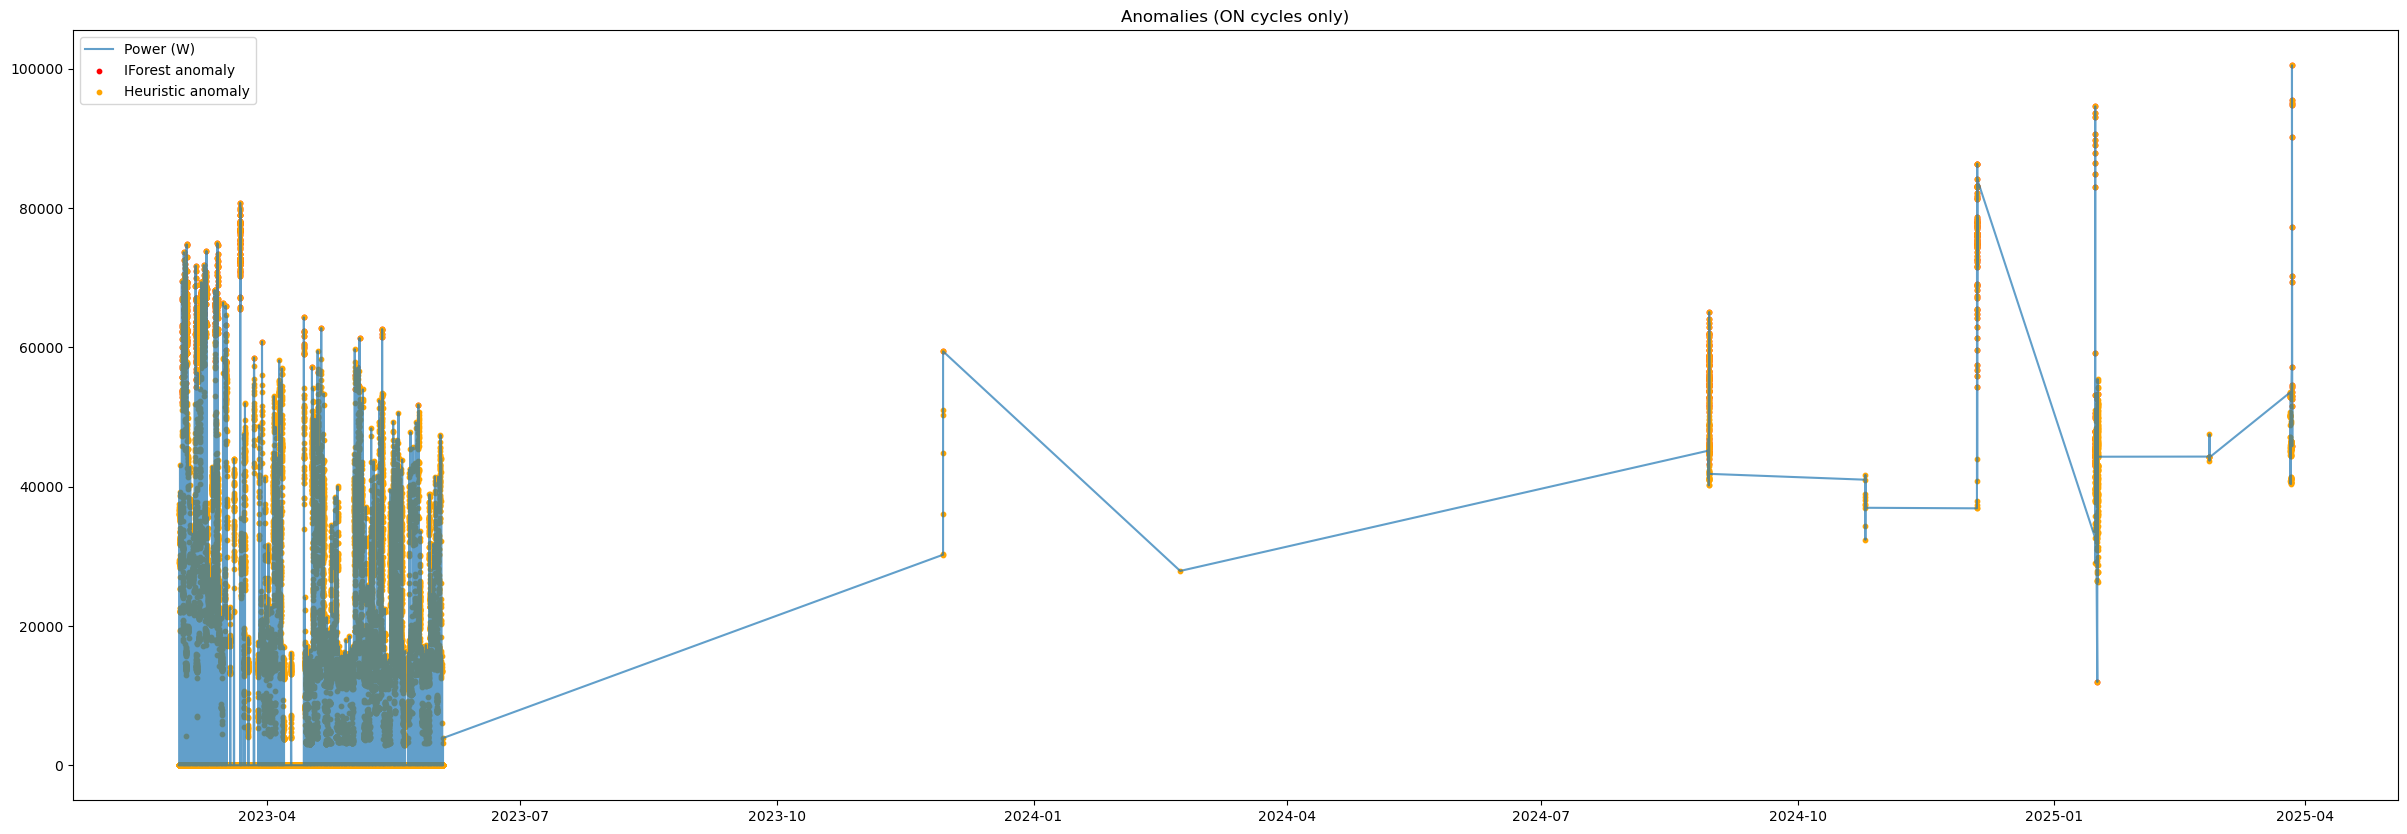

In [6]:
plt.figure(figsize=(30,10))
plt.plot(df_on['time'], df_on['ptot_W'], label="Power (W)", alpha=0.7)

plt.scatter(
    df_on.loc[df_on['iforest_anomaly']==1, 'time'],
    df_on.loc[df_on['iforest_anomaly']==1, 'ptot_W'],
    color='red', s=10, label="IForest anomaly"
)

plt.scatter(
    df_on.loc[df_on['heuristic_anomaly']==1, 'time'],
    df_on.loc[df_on['heuristic_anomaly']==1, 'ptot_W'],
    color='orange', s=10, label="Heuristic anomaly"
)

plt.legend()
plt.title("Anomalies (ON cycles only)")
plt.show()



5. Overlap Between Methods

In [7]:
# Compare anomaly sets
overlap = pd.crosstab(df_on['iforest_anomaly'], df_on['heuristic_anomaly'],
                      rownames=['IsolationForest'], colnames=['Heuristic'])
print(overlap)


Heuristic            1
IsolationForest       
0                64502
1                  652


6. Train XGBoost Models (Evaluation)

Define a helper function:

In [8]:
def train_and_eval(X, y, label_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"\n=== {label_name} ===")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))

    plot_importance(model, max_num_features=15)
    plt.title(f"Feature Importance ({label_name})")
    plt.show()
    return model


c:\Users\tiaan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Isolation Forest ===
[[12901     8]
 [    9   113]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12909
           1       0.93      0.93      0.93       122

    accuracy                           1.00     13031
   macro avg       0.97      0.96      0.96     13031
weighted avg       1.00      1.00      1.00     13031

ROC-AUC: 0.962804892761309


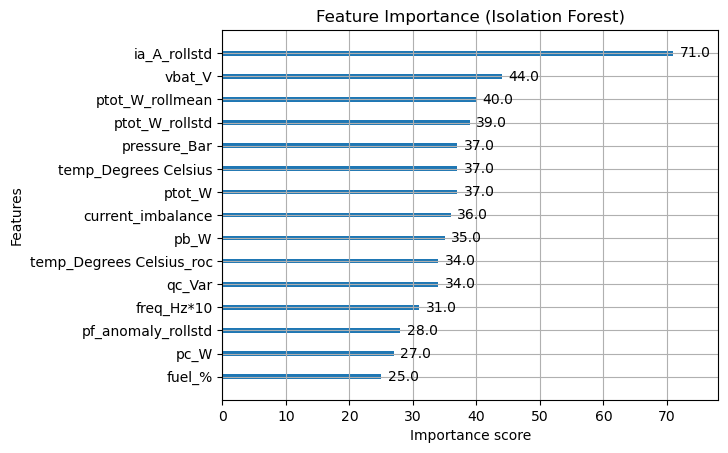

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
# Isolation Forest labels
train_and_eval(X_on, df_on['iforest_anomaly'], "Isolation Forest")






In [10]:
# Heuristic labels
train_and_eval(X_on, df_on['heuristic_anomaly'], "Heuristic")

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

c:\Users\tiaan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== One-Class SVM ===
[[  32  928]
 [ 100 2940]]
              precision    recall  f1-score   support

           0       0.24      0.03      0.06       960
           1       0.76      0.97      0.85      3040

    accuracy                           0.74      4000
   macro avg       0.50      0.50      0.45      4000
weighted avg       0.64      0.74      0.66      4000

ROC-AUC: 0.5002192982456141


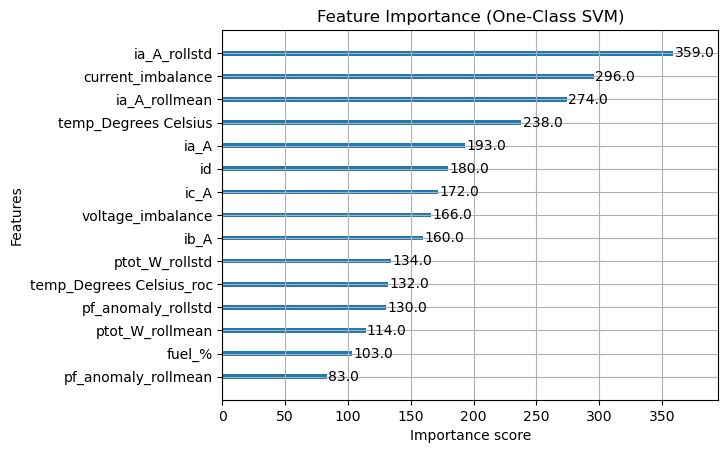

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
# (Optional) One-Class SVM (if you computed)
train_and_eval(X_sample[feature_cols], df_sample['ocsvm_anomaly'], "One-Class SVM")